**Tom DA SILVA-FARIA**
# **InceptionResnetV2 (UNET) training/testing notebook** :
This notebook is made to train and test a model based on articles [1] and [2]. 

In [1]:
#%% imports
import sys, torch
sys.path.append("./_MODEL")
sys.path.append("../_COMMONS")

import numpy as np
from datetime import datetime

from torch.optim import Adam, lr_scheduler
from torchvision import transforms
from torch.utils.data import DataLoader

from torch_metrics import Loss
from torch_dataset import AODataset, generate_paths
from torch_InceptionResnetV2 import InceptionResnetV2
from torch_training import train_loop
from torch_testing import test_model

from CONFIG import *

## A - Dataset loading :

In [2]:
# Images transformations/augmentation
transf = transforms.Compose([
        transforms.ToPILImage(), 
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)), 
        transforms.ToTensor()
    ])

# Loading dataset (train, test and validation)
train, val, test = generate_paths(DATASET_PATH, SPLIT_RATE)
trainDataset = AODataset(train, transf=transf)
valDataset   = AODataset(val,   transf=transf)
testDataset  = AODataset(test,  transf=transf)

# Creating dataloaders
trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=BATCH_SIZE,
                         pin_memory=False) #, num_workers=os.cpu_count())
valLoader   = DataLoader(valDataset, shuffle=False, batch_size=BATCH_SIZE, 
                         pin_memory=False) #, num_workers=os.cpu_count())

Loaded dataset : 535 images
Loaded dataset : 12 images
Loaded dataset : 19 images


## B - Defining model, loss and optimizer

In [3]:
model = InceptionResnetV2(name="InceptionResnetV2", inCh=1, outCh=1).to(DEVICE)
loss = Loss(name = LOSS)
opt  = Adam(model.parameters(), lr=LEARNING_RATE)
sch  = lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.2, 
                                          patience=2, min_lr=0.0005)

Chosen loss : Tversky loss


## C - **Training model**

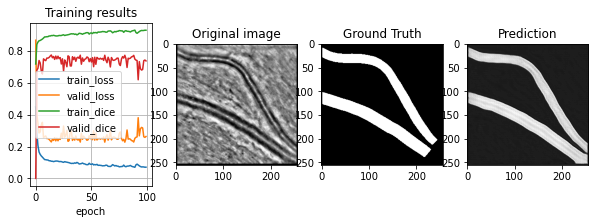

Current learning rate : 0.0005
train loss : 0.07034 --- validation loss : 0.26287
train dice : 0.92991 --- validation dice : 0.73733

[INFO] - Saving checkpoint
[END] - Training ended after 00:27:39


In [4]:
# Train steps and loss dict
tStep, sStep = len(trainDataset)/BATCH_SIZE, len(valDataset)/BATCH_SIZE
if tStep > int(tStep) : tStep = int(tStep) + 1
if sStep > int(sStep) : sStep = int(sStep) + 1
tStep, sStep = int(tStep), int(sStep)

H, trainedModel, fChck = train_loop(model, trainLoader, valLoader, loss, opt, sch,
                                EPOCHS, tStep, sStep, DEVICE, CKP_STEP, plot=True)

In [5]:
now = datetime.now()   
dt_string = now.strftime("%d%m%Y_%H%M%S")
filename = f"Checkpoints/{model.name}_{loss.name}_{dt_string}.npz"
np.savez(filename, **H)

## D - **Testing model**

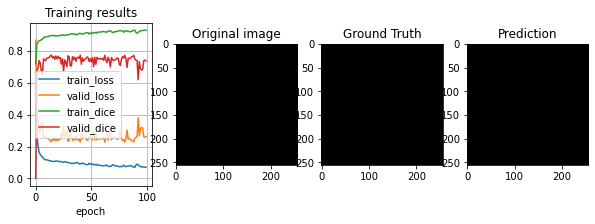

  0%|          | 0/19 [00:00<?, ?it/s]

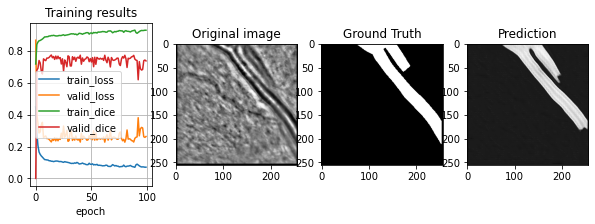

  5%|▌         | 1/19 [00:00<00:05,  3.54it/s]

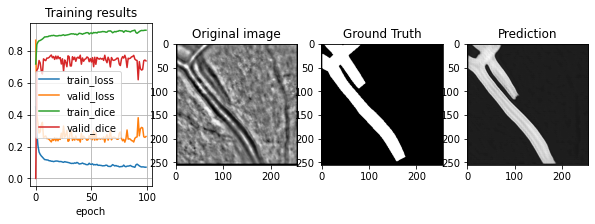

 11%|█         | 2/19 [00:00<00:04,  3.74it/s]

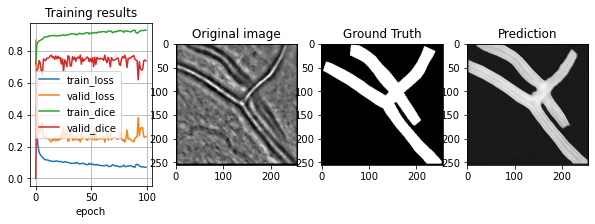

 16%|█▌        | 3/19 [00:00<00:04,  3.81it/s]

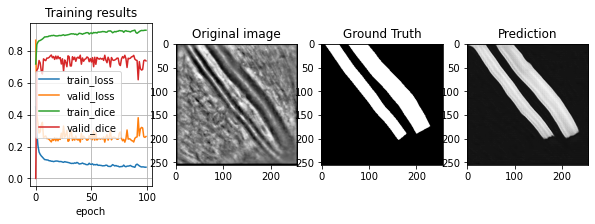

 21%|██        | 4/19 [00:01<00:03,  3.83it/s]

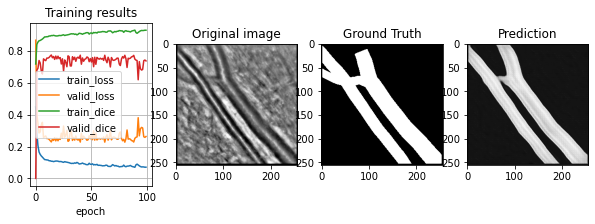

 26%|██▋       | 5/19 [00:01<00:04,  3.39it/s]

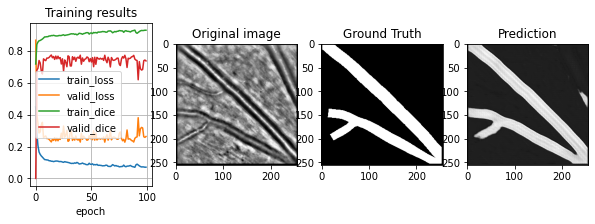

 32%|███▏      | 6/19 [00:01<00:03,  3.54it/s]

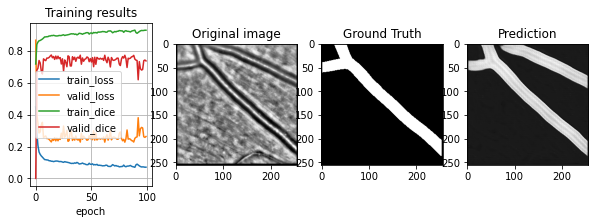

 37%|███▋      | 7/19 [00:01<00:03,  3.64it/s]

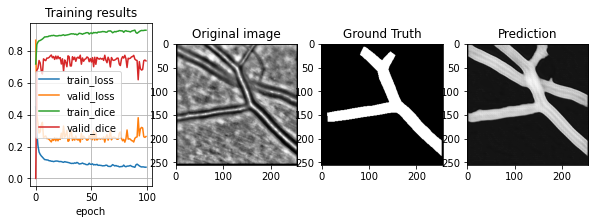

 42%|████▏     | 8/19 [00:02<00:02,  3.72it/s]

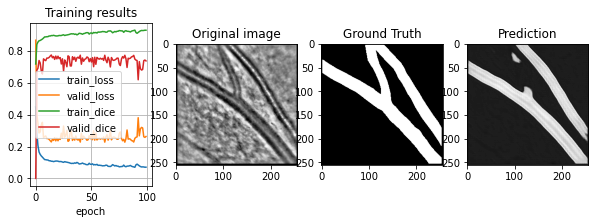

 47%|████▋     | 9/19 [00:02<00:02,  3.77it/s]

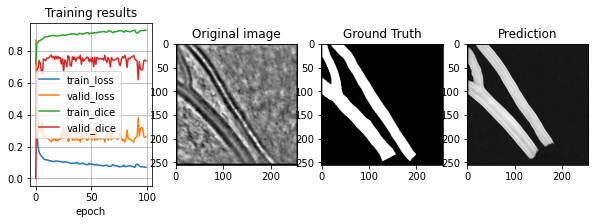

 53%|█████▎    | 10/19 [00:02<00:02,  3.80it/s]

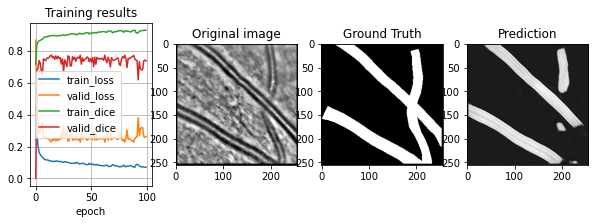

 58%|█████▊    | 11/19 [00:03<00:02,  3.42it/s]

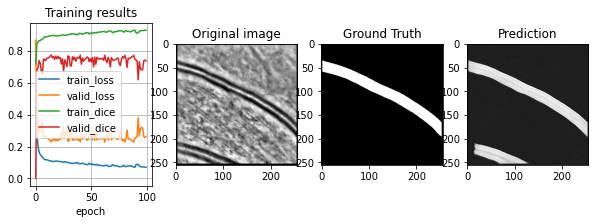

 63%|██████▎   | 12/19 [00:03<00:01,  3.54it/s]

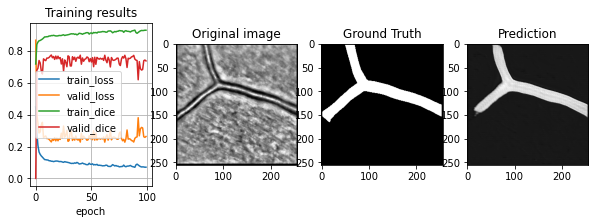

 68%|██████▊   | 13/19 [00:03<00:01,  3.64it/s]

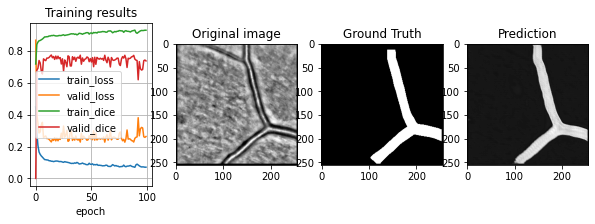

 74%|███████▎  | 14/19 [00:03<00:01,  3.71it/s]

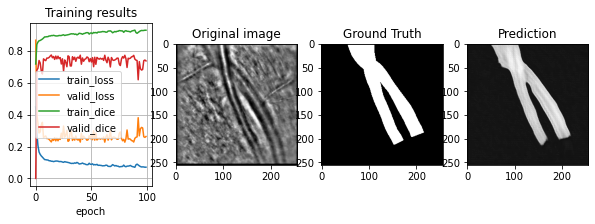

 79%|███████▉  | 15/19 [00:04<00:01,  3.75it/s]

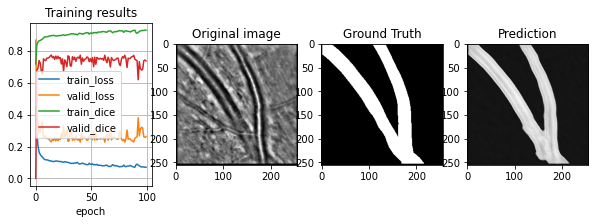

 84%|████████▍ | 16/19 [00:04<00:00,  3.79it/s]

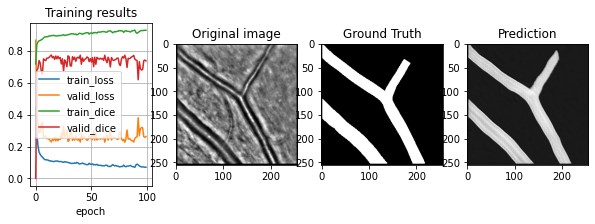

 89%|████████▉ | 17/19 [00:04<00:00,  3.42it/s]

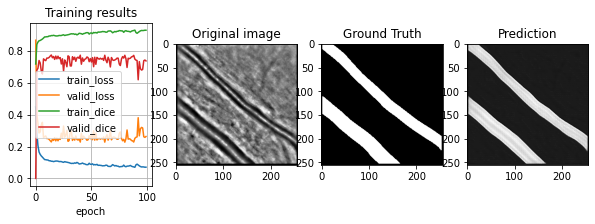

 95%|█████████▍| 18/19 [00:04<00:00,  3.54it/s]

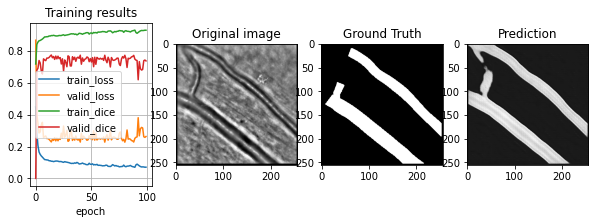

100%|██████████| 19/19 [00:05<00:00,  3.64it/s]


In [6]:
SAVE_PATH = fChck
RSLT_PATH = filename

testLoader  = DataLoader(testDataset, shuffle=False, batch_size=1,
                             pin_memory=False)#, num_workers=os.cpu_count()

model = InceptionResnetV2(name="InceptionResnetV2", inCh=1, outCh=1)
model.load_state_dict(torch.load(SAVE_PATH)['state_dict'], strict=False)
model = model.to(DEVICE)

test_model(model, testLoader, rsltPath=RSLT_PATH, dev=DEVICE)